# https://distill.pub/2020/growing-ca/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import random
import requests
import io

%matplotlib inline

In [2]:
device='cuda:0'

In [3]:
class Perception(nn.Module):
    def __init__(self, learnable=False):
        super().__init__()
        sobel_x = (torch.tensor([[-1, 0, +1],
                                [-2, 0, +2],
                                [-1, 0, +1]]).float() / 8)[None, None, ...].repeat(16, 16, 1, 1)
        sobel_y = (torch.tensor([[-1, -2, -1],
                                [0, 0, 0],
                                [-1, -2, -1]]).float() / 8)[None, None, ...].repeat(16, 16, 1, 1)
        idt = (torch.tensor([[0, 0, 0],
                            [0, 1, 0],
                            [0, 0, 0]]).float())[None, None, ...].repeat(16, 16, 1, 1)
        if learnable:
            self.sobel_x = nn.Parameter(sobel_x, requires_grad=True)
            self.sobel_y = nn.Parameter(sobel_y, requires_grad=True)
            self.identity = nn.Parameter(idt, requires_grad=True)

        else:
            self.sobel_x = nn.Parameter(sobel_x, requires_grad=False)
            self.sobel_y = nn.Parameter(sobel_y, requires_grad=False)
            self.identity = nn.Parameter(idt, requires_grad=False)


    def forward(self, state_grid):
        grad_x = F.conv2d(state_grid, self.sobel_x, padding=1)
        grad_y = F.conv2d(state_grid, self.sobel_y, padding=1)
        idt = F.conv2d(state_grid, self.identity, padding=1)
        perception_grid = torch.cat([state_grid, grad_x, grad_y],  dim=1)
        return perception_grid

class Policy(nn.Module):
    def __init__(self, state_dim=16, interm_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(state_dim * 3, interm_dim, 1)
        self.conv2 = nn.Conv2d(interm_dim, state_dim, 1)
        nn.init.constant_(self.conv2.weight, 0.01)
        nn.init.constant_(self.conv2.bias, 0)
        
    def forward(self, state):
        interm = self.conv1(state)
        interm = torch.relu(interm)
        return self.conv2(interm)
    
def stochastic_update_mask(ds_grid, prob=0.5):
    # Zero out a random fraction of the updates.
    bern = torch.distributions.Bernoulli(prob)
    rand_mask = bern.sample_n(ds_grid.shape[2] * ds_grid.shape[3]).view(ds_grid.shape[2:]).float().to(ds_grid.device)
    return rand_mask

def alive_mask(state_grid, thr=0.1):
    # Take the alpha channel as the measure of “life”.
    alive = (state_grid[:, 4, :, :].clamp(0, 1) > thr).float().unsqueeze(1)#.repeat(1, 16, 1, 1)
    return alive


In [4]:
def load_image(url, max_size=32):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img

def load_emoji():
    url = 'https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u0023.png'
    return load_image(url)

In [5]:
# target = Image.open('/mnt/evo/Data/wikiart/wikiart/Cubism/aristarkh-lentulov_self-portrait-1915.jpg').convert('RGB').resize((32, 32))
# target = torchvision.transforms.ToTensor()(target)
# target = torchvision.transforms.Normalize((0.5, 0.5, 0.5),
#                                           (0.5, 0.5, 0.5))(target).unsqueeze(0).to(device)
# target[:, :, :5] *= 0
# target[:, :, -5:] *= 0
# target[:, :, :, :5] *= 0
# target[:, :, :, -5:] *= 0

target = load_emoji()
target = torchvision.transforms.ToTensor()(target)
target = target.unsqueeze(0).to(device)


In [6]:
state_grid = torch.zeros((1, 16, 32, 32), requires_grad=False, device=device)
state_grid[0, :, random.randint(14, 18), random.randint(14, 18)] += 1.
alive_mask(state_grid).shape

torch.Size([1, 1, 32, 32])

In [7]:
policy = Policy().to(device)
perception = Perception(learnable=False).to(device)
optim = torch.optim.Adam(policy.parameters())
loss_fn = nn.MSELoss(reduction='mean')

In [8]:
for step in range(30):
    optim.zero_grad()
    state_grid = torch.zeros((1, 16, 32, 32), requires_grad=False, device=device)
    state_grid[0, 3:, 16, 16] += 1.
    imgs = []
    for k in range(100):
        alive_pre = alive_mask(state_grid)
        perception_grid = perception(state_grid)
        ds_grid = policy(perception_grid)
        mask = stochastic_update_mask(ds_grid, prob=0.3)
        state_grid = state_grid + ds_grid * mask
        alive_post = alive_mask(state_grid)
        state_grid = state_grid * alive_post
        imgs.append(state_grid.detach().cpu()[0].permute(1, 2, 0).data.numpy())
    loss_value = loss_fn(target[:, :4, ...], torch.sigmoid(state_grid[:, :4, ...]))
    loss_value.backward()
    optim.step()
    print(loss_value.item())

/opt/conda/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349
0.91134113073349


In [9]:
alive_post.sum()

tensor(1024., device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


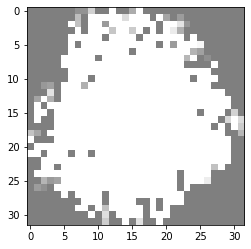

In [10]:
plt.imshow((imgs[20][:, :, :3] + 1.) / 2.)

In [11]:
target[:, :3].max()

tensor(0.5020, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


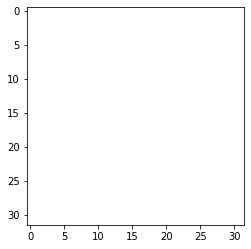

In [15]:
plt.imshow(state_grid[0, :3, ...].cpu().permute(1, 2, 0).data.numpy())

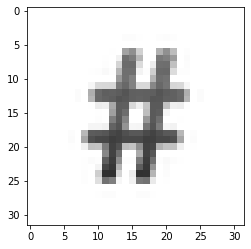

In [14]:
plt.imshow(target[0].cpu().permute(1, 2, 0).data.numpy())